In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [9]:
data = pd.read_csv('test_restaurant.csv', parse_dates = ['date'],index_col = ['date'])

In [5]:
data.head()

,date,num_visitors
0,2000-01-01,49.128490
1,2000-01-02,50.288060
2,2000-01-03,53.549213
3,2000-01-04,45.453240
4,2000-01-05,49.469402


In [21]:
ts = data['num_visitors']

print(ts)

            num_visitors
date                    
2000-01-01     49.128490
2000-01-02     50.288060
2000-01-03     53.549213
2000-01-04     45.453240
2000-01-05     49.469402
...                  ...
2009-12-25     31.124632
2009-12-26     27.293856
2009-12-27     30.218498
2009-12-28     24.751186
2009-12-29     66.118840

[3649 rows x 1 columns]


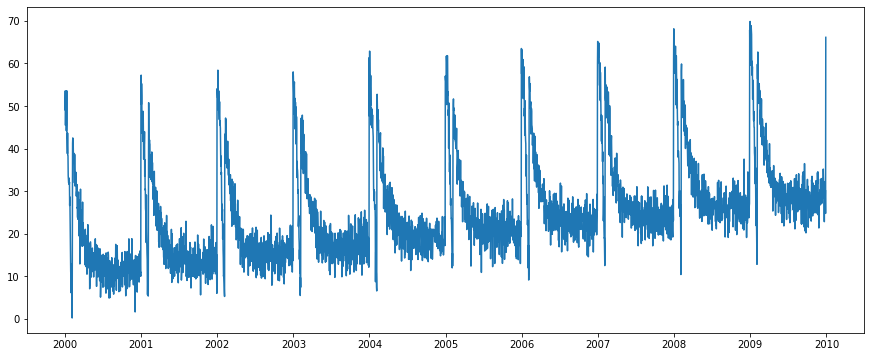

In [23]:
plt.plot(ts)

### We can clearly observe seasonality and trend in the above graph

In [24]:
ts1 = data[(data[['num_visitors']] > 0).all(1)]
ts_log = np.log(ts1)

In [25]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

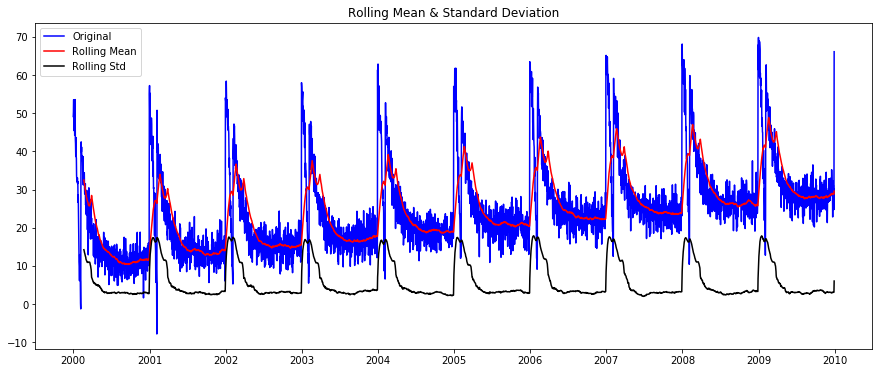

Results of Dickey-Fuller Test:
Test Statistic                   -4.322697
p-value                           0.000406
#Lags Used                       30.000000
Number of Observations Used    3620.000000
Critical Value (1%)              -3.432158
Critical Value (5%)              -2.862339
Critical Value (10%)             -2.567195
dtype: float64


In [26]:
test_stationarity(data['num_visitors'])

### P is below 0.5 and Critical Value at 5% is greater than Test Statistic  so we can say that  time series is stationary

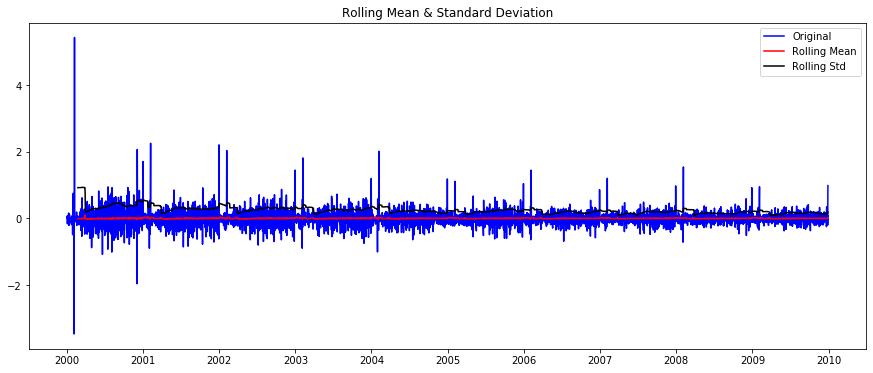

Results of Dickey-Fuller Test:
Test Statistic                -1.790042e+01
p-value                        2.954795e-30
#Lags Used                     3.000000e+01
Number of Observations Used    3.617000e+03
Critical Value (1%)           -3.432159e+00
Critical Value (5%)           -2.862339e+00
Critical Value (10%)          -2.567196e+00
dtype: float64


In [42]:
ts_log_shift = ts_log - ts_log.shift()
ts_log_shift.dropna(inplace=True)
test_stationarity(ts_log_shift)


/Users/tejaspatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


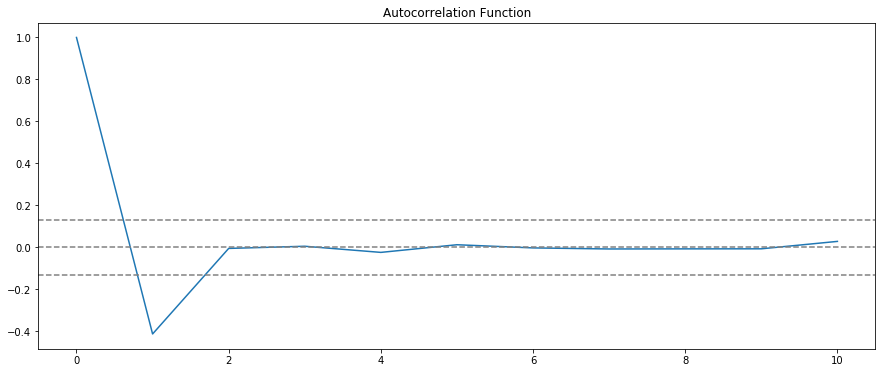

In [45]:
plt.plot(np.arange(0,11), acf(ts_log_shift, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

### The ACF curve crosses the upper confidence value when the lag value is between 0 and 1. Thus optimal value of q in the ARIMA model must be 0 or 1

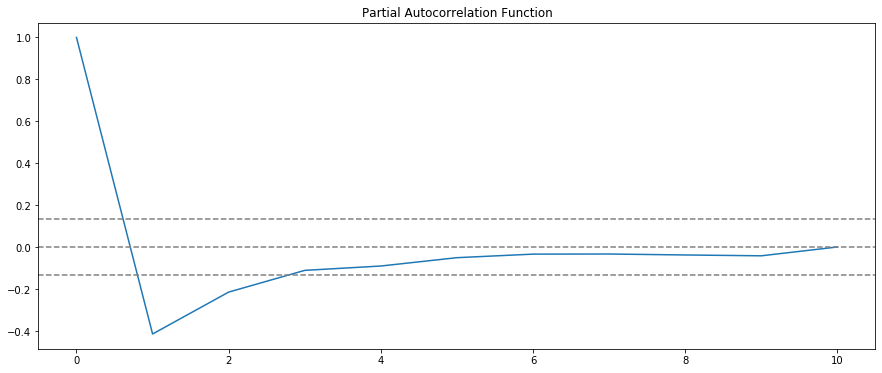

In [46]:
plt.plot(np.arange(0,11), pacf(ts_log_shift, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_shift)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_shift)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

### The PACF curve drops to 0 between lag values 0 and 2. Thus optimal value of p in the ARIMA model is 1 or 2.

/Users/tejaspatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/tejaspatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


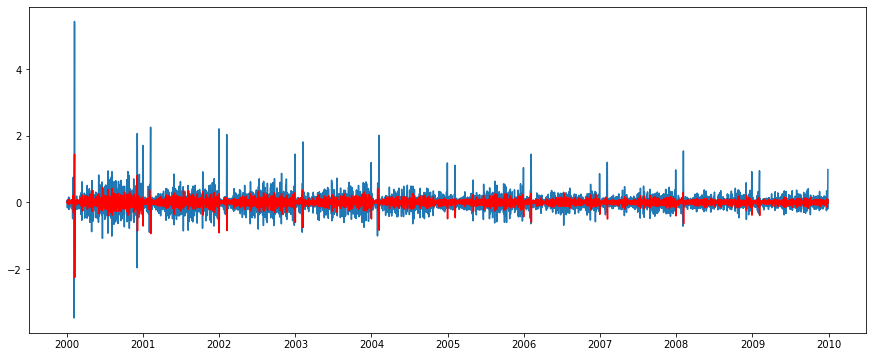

In [48]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_shift)**2))

In [49]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2000-01-02    4.812113e-07
2000-01-03   -9.691119e-03
2000-01-04   -2.610333e-02
2000-01-05    6.809963e-02
2000-01-06   -3.517538e-02
dtype: float64

In [50]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2000-01-02    4.812113e-07
2000-01-03   -9.690637e-03
2000-01-04   -3.579396e-02
2000-01-05    3.230567e-02
2000-01-06   -2.869710e-03
dtype: float64

In [78]:
predictions_ARIMA_log = pd.Series(ts_log['num_visitors'].iloc[1], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2000-01-01    3.917768
2000-01-02    3.917768
2000-01-03    3.908077
2000-01-04    3.881974
2000-01-05    3.950073
dtype: float64

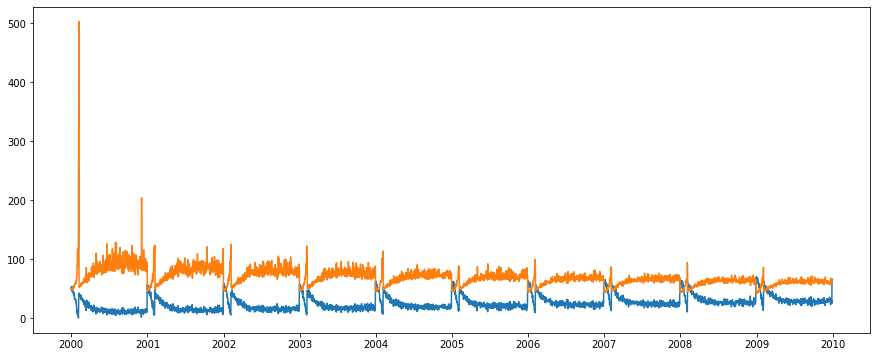

In [64]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
#results.plot_predict(1,264)plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### The orange curve is our prediction.While our model is not good in predicting trend and seasonality



/Users/tejaspatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/tejaspatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/tejaspatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


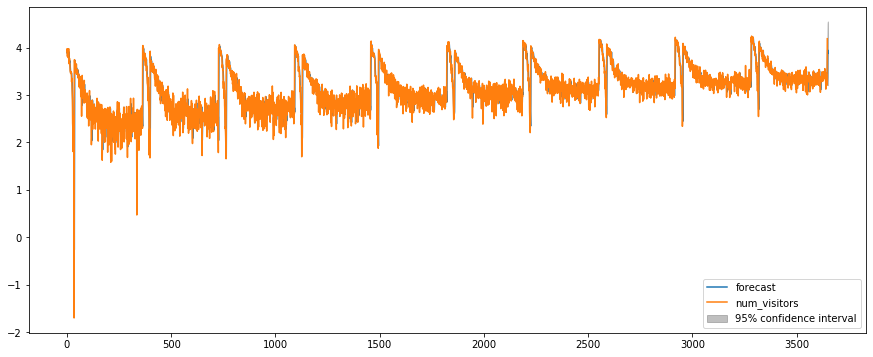

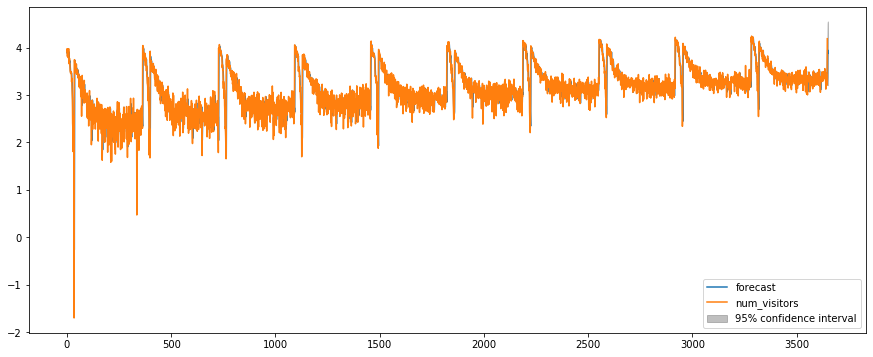

In [81]:
results_ARIMA.plot_predict(1,3651)

### Conclusion for the next day forcast :-
### According to our forcast number of visitor on next day will increase siginificantly